In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from logging import ERROR
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel(ERROR)

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime
import matplotlib.pyplot as plt
from IPython.display import display
import keras.backend as K
from matplotlib import ticker

from tqdm.notebook import tqdm

from ipywidgets import IntSlider, ToggleButton, Checkbox, interact, HTML
import seaborn as sns

from utils import RELEVANT_COLUMNS

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# df_weekly = pd.read_csv('../data/clean/df_weekly.csv')
df_weekly = pd.read_csv('../data/clean/df_weekly_incidence.csv')

In [4]:
'''
Teile die In-Seqeuenz (Feature) in einzelne Sequenzen der Länge n_steps_in und
die Out-Sequenz (Target) in einzelne Sequenzen der Länge n_steps_out.

Beispiel: n_steps_in=1, n_steps_out=2
           Feature  | Target
    Seq 1:    1         -
        |     2         -
        |     3         6
        |     -         8       

@param overap 
Sollen sich die einzelnen Sequenzen überlappen?
    Standardmäßig überlappen sich die Daten der Sequenzen:
        1. Seq [1,2,3]
        2. Seq [2,3,4]
    mit overlap = False:
        1. Seq [1,2,3]
        2. Seq [4,5,6]

'''
def split_sequence(in_sequence, out_sequence, n_steps_in, n_steps_out, overlap=True, last_feature_as_target=True):
    X, y = list(), list()
    step = 1 if overlap else n_steps_in
    left_over = 0 
    target_offset = 1 if last_feature_as_target else 0

    for i in range(0,len(in_sequence),step):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - target_offset
        # check if we are beyond the sequence
        if (out_end_ix > len(in_sequence)):
            left_over = len(in_sequence) - i
            break
   
        # gather input and output parts of the pattern     
        seq_x, seq_y = in_sequence[i:end_ix,:],  out_sequence[end_ix-target_offset:out_end_ix,-1] #out_sequence[end_ix-1:out_end_ix,-1]
        X.append(seq_x)
        y.append(seq_y)

       
    return np.array(X), np.array(y), left_over

def split_sequence_variable(df, in_sequence, out_sequence, n_steps_in=(5,20), n_steps_out=6,overlap=True,train_split=0.8):
    droped_indices = []
    lk_end = False
    X_train, X_test, y_train, y_test = list(), list(), list(), list()

    df_train, df_test = pd.DataFrame(), pd.DataFrame()
    

    lk_X , lk_y = list(), list()
    # step = 1 if overlap else n_steps
    steps_l, steps_h = n_steps_in
    landkreise = df.administrative_area_level_3.unique()
    for lk in landkreise:
        lk_dropped_incides = []
        df_lk = df[df.administrative_area_level_3 == lk]
        df_lk_index_min = df_lk.index.min()
        df_lk_index_max = df_lk.index.max()
        df_lk_len = len(df_lk)-1
        for i in range(df_lk_index_min,df_lk_index_max):
            n_steps = np.random.randint(steps_l, steps_h)
            # find the end of this pattern
            end_ix = i + n_steps
            out_end_ix = end_ix + n_steps_out -1
            
            
            seq_not_fixed = True                   
            lk_end = False
            drop_index = False
            # reduziere In Sequencegröße bis es passt oder die minimale Größe erreicht wurde
            while (out_end_ix > df_lk_index_max) and seq_not_fixed:
                n_steps -=1
                end_ix = i + n_steps 
                out_end_ix = end_ix + n_steps_out -1
                if n_steps < steps_l:     # Wenn Feature Sequenz zu klein (minimale Länge = 5), schmeiß weg      
                    drop_index = True
                    seq_not_fixed = False  
                    lk_dropped_incides.extend([x-df_lk_index_min for x in range(i,df_lk_index_max)]) 
                    lk_end = True
            if lk_end:
                break


            # # check if we are beyond the sequence
            # seq_not_fixed = False
            # if out_end_ix > df_lk_len:
            #     seq_not_fixed = True
            #     n_steps = steps_h

            # drop_index = False
            # while (seq_not_fixed):
            #     out_end_ix = df_lk_len
            #     end_ix = max(i,out_end_ix - n_steps +1)
            #     if out_end_ix > df_lk_len: seq_not_fixed = True

            #     if i > steps_l and ((end_ix - i )< steps_l):
            #         seq_not_fixed = True
            #     if n_steps < steps_l:     # Wenn Feature Sequenz zu klein (minimale Länge = 5), schmeiß weg      
            #         drop_index = True
            #         seq_not_fixed = False                
            #     n_steps -1


            # start_row = df.iloc[i]
            # end_row = df.iloc[out_end_ix]

            # lk_of_seq_start = start_row.administrative_area_level_3
            # lk_of_seq_end = end_row.administrative_area_level_3

            # Wenn es nicht mehr genug "Zeilen" für eine volle Sequenz gibt, nimm den rest
            # if (lk_of_seq_start != lk_of_seq_end):
            #     for j in range(1,n_steps):
            #         prev_lk = df.iloc[out_end_ix-j].administrative_area_level_3
            #         if prev_lk == lk_of_seq_start:
            #             out_end_ix = out_end_ix-j # setzte das Ende der Target Sequenz auf die letzte Zeile des LKs
            #             end_ix = out_end_ix - n_steps_out +1# setzte das Ende der feature Sequnze um n_steps_out zurück, damit die Target Sequenz die richtige Größe hat
            #             break
            

            if drop_index:                
                lk_dropped_incides.append(i-df_lk_index_min) 
                # lk_end = True  
            else:
                seq_x, seq_y = in_sequence[i:end_ix,:],  out_sequence[end_ix-1:out_end_ix,-1] #out_sequence[end_ix-1:out_end_ix,-1]
                lk_X.append(seq_x)
                lk_y.append(seq_y) 
        
        train_size = int(len(lk_X) * train_split)
        
        df_lk.drop(df_lk.index[lk_dropped_incides])

        X_train.extend(lk_X[:train_size])
        tmp = lk_X[train_size:]
        X_test.extend(tmp)
        y_train.extend(lk_y[:train_size])
        y_test.extend(lk_y[train_size:])
        df_train = pd.concat([df_train,df_lk.iloc[:train_size+n_steps_out]])
        tmp2 = df_lk.iloc[train_size:]
        tmp_l = len(tmp)
        tmp_2l = len(tmp2)
        df_test = pd.concat([df_test,tmp2])
        

        lk_X , lk_y = list(), list()
        lk_end = False
        droped_indices.extend(lk_dropped_incides)
    
    
    df = df.drop(df.index[droped_indices])
    X_train_out = tf.keras.preprocessing.sequence.pad_sequences(X_train,value=-1,dtype="float32",maxlen=steps_h)
    X_test_out = tf.keras.preprocessing.sequence.pad_sequences(X_test,value=-1,dtype="float32",maxlen=steps_h)
    
    y_train_out = np.array(y_train)
    y_test_out = np.array(y_test)

    print(len(droped_indices))
    return df_train, df_test, X_train_out, X_test_out, y_train_out, y_test_out

'''
Prüfe, ob in einer Sequenzen basieren auf den IN und OUT Steps 
LK übergreifenden Daten vorkommen.
Entferne Zeilen, welche nicht mehr für eine volle Sequenz verwendet werden können

BSP:
    1. LK Erfurt
    2. LK Erfurt
    3. LK Erfurt
    4. LK Ahrweiler
    5. LK Ahrweiler

'''
def prepare_df_for_sequencing(df,n_steps_in, n_steps_out):
    droped_indices = []
    df_len = len(df)-1
    for i in range(0,df_len):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out -1
        # check if we are beyond the sequence
        if (out_end_ix > df_len):
            break
        start_row = df.iloc[i]
        end_row = df.iloc[out_end_ix]

        lk_of_seq_start = start_row.administrative_area_level_3
        lk_of_seq_end = end_row.administrative_area_level_3

        # Wenn es nicht mehr genug "Zeilen" eines LKs gibt müssen diese entfernt werden
        if (lk_of_seq_start != lk_of_seq_end):
            droped_indices.append(i)          
    
    df = df.drop(df.index[droped_indices])
    return df

def split_for_training(df, features, target,split_perc):
    df_train, df_test = pd.DataFrame(), pd.DataFrame()
    

    lks = df.administrative_area_level_3.unique()
    train_indices = np.array([],dtype="int") #pd.Index([],dtype=np.int64) 
    test_indices = np.array([],dtype="int") #pd.Index([],dtype=np.int64) 
    for lk in lks:
        # df_lk = df[df.administrative_area_level_3 == lk]

        indices = df.index.get_indexer_for(df[df.administrative_area_level_3 == lk].index)
        train_size = int(len(indices) * split_perc)
        # train_indices = train_indices.append(indices[:train_size])
        # test_indices = test_indices.append(indices[train_size:])  
        train_indices = np.concatenate([train_indices,indices[:train_size]])
        test_indices = np.concatenate([test_indices,indices[train_size:]])
    
    # train_indices = train_indices.drop(train_indices.max())
    # train_indices = train_indices.re
    train_features_lstm, test_features_lstm = features[train_indices], features[test_indices]
    train_target_lstm, test_target_lstm = target[train_indices], target[test_indices]

    df_train = pd.concat([df_train,df.iloc[train_indices]])
    df_test = pd.concat([df_test,df.iloc[test_indices]])


    return df_train, df_test, train_features_lstm, test_features_lstm, train_target_lstm, test_target_lstm


In [6]:
# Defines
TIME_STEPS_IN = 10
TIME_STEPS_OUT = 6
DATA_OVERLAP = True
# TARGET_COLUMN = "incidence"
TARGET_COLUMN = ""
TARGET_COLUMN = "incidence"
TRAIN_DATA_COLUMNS = None
TARGET_COLUMN_INDEX = 0
TRAIN_SPLIT = 0.8

print("DF Full:",len(df_weekly))

df_weekly_adjusted = prepare_df_for_sequencing(df_weekly,TIME_STEPS_IN, TIME_STEPS_OUT)
df_weekly_adjusted.update(df_weekly_adjusted.select_dtypes(include=[np.number]).abs()) ## take absolute of every value
data = df_weekly_adjusted[RELEVANT_COLUMNS]

TRAIN_DATA_COLUMNS = data.columns
TARGET_COLUMN_INDEX = TRAIN_DATA_COLUMNS.get_loc(TARGET_COLUMN)
DATA_LK_NAMES = df_weekly_adjusted.administrative_area_level_3.unique()
DATA_LK_COUNT = len(DATA_LK_NAMES)
 

DF Full: 58920


In [7]:
'''
Min und Max für alle Spalten berechnen.

'''
def minMax(x,multiplier):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()*multiplier])

data_min_max = data.apply(minMax,multiplier=2).to_numpy()

In [8]:

data = np.array(data)

print("Data:",data.shape)

# Vorbereitung der Eingangsdaten (Features) und der Zielvariablen
features = data[:, :-1] 
target = data[:, -1]


# features = np.zeros((data.shape[0],4))
# target = data[:, -1]
# features[:,:3] = data[:,:3] ## nur die ersten 3 columns

# features[:,-1] =  data[:,TRAIN_DATA_COLUMNS.get_loc("population")]## nur die ersten 3 columns
print("Features:",features.shape,"Target:",target.shape)

N_FEATURES = features.shape[-1]

# feat_range = (-1,1) # tanh
feat_range = (0,1) # relu

# Daten normalisieren
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(data_min_max[:, :-1])
target_scaler.fit(data_min_max[:, -1].reshape(-1,1))


features_scaled = feature_scaler.transform(features)
target_scaled = target_scaler.transform(target.reshape(-1, 1))
print("Features Scaled:",features_scaled.shape,"Target Scaled:",target_scaled.shape)
## SCALING Muss nach sequenzierung passieren, sonst passt die Normaliseirung nicht, wenn Werte fehlen

# df_train, df_test,train_features_lstm, test_features_lstm, train_target_lstm, test_target_lstm = split_sequence_variable(df_weekly,features_scaled,target_scaled, (5,6), TIME_STEPS_OUT, overlap=DATA_OVERLAP,train_split=TRAIN_SPLIT)
# train_features_lstm, test_features_lstm, train_target_lstm, test_target_lstm = split_for_training(feature_seqs,target_seq,df_weekly_adjusted,0.8)


feature_seqs,target_seq, left_over =  split_sequence(features_scaled,target_scaled, TIME_STEPS_IN, TIME_STEPS_OUT, overlap=DATA_OVERLAP)
df_weekly_adjusted = df_weekly_adjusted.drop(df_weekly_adjusted.index[-left_over:])
print("Features Seq.:",feature_seqs.shape,"Target Seq.:",target_seq.shape, "DF Adjust.:",len(df_weekly_adjusted),"Left_over:",left_over)




# train_size = int(len(feature_seqs) * 0.8)
# test_size = len(feature_seqs) - train_size
# print("Train Size: {}, Test Size: {}".format(train_size,test_size))



# train_features_lstm, test_features_lstm = feature_seqs[:train_size], feature_seqs[train_size:]
# train_target_lstm, test_target_lstm = target_seq[:train_size], target_seq[train_size:]
df_train, df_test, train_features_lstm, test_features_lstm, train_target_lstm, test_target_lstm = split_for_training(df_weekly_adjusted, feature_seqs, target_seq, 0.8) 

print("----------------------------------------")
print("TRAIN F:",train_features_lstm.shape,"TEST F:",test_features_lstm.shape,"DF Train:",len(df_train),"DF Test:",len(df_test))
print("TRAIN T:",train_target_lstm.shape,"TEST T:",test_target_lstm.shape)
print(train_features_lstm[0,:,:2],train_target_lstm[0,:])
# print(train_features_lstm[1,:,:2],train_target_lstm[1,:])





Data: (52755, 24)
Features: (52755, 23) Target: (52755,)
Features Scaled: (52755, 23) Target Scaled: (52755, 1)
Features Seq.: (52741, 10, 23) Target Seq.: (52741, 6) DF Adjust.: 52741 Left_over: 14
----------------------------------------
TRAIN F: (42014, 10, 23) TEST F: (10727, 10, 23) DF Train: 42014 DF Test: 10727
TRAIN T: (42014, 6) TEST T: (10727, 6)
[[5.54892382e-06 0.00000000e+00]
 [2.35829262e-05 0.00000000e+00]
 [3.95360822e-05 1.59744409e-04]
 [5.68764692e-05 1.59744409e-04]
 [7.21360097e-05 1.59744409e-04]
 [7.83785490e-05 1.59744409e-04]
 [8.04593954e-05 1.59744409e-04]
 [8.67019347e-05 1.59744409e-04]
 [9.77997823e-05 1.59744409e-04]
 [1.09591245e-04 1.59744409e-04]] [0.0016117  0.00198364 0.00086784 0.00037193 0.00037193 0.        ]


In [9]:
''' 
Encoder-Decoder Architecture für Sequence to Sequence
https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/

'''
K.clear_session()

stateful = False
# activ = 'tanh'
activ = 'relu'
# loss = tf.keras.losses.MeanSquaredError()
loss = "mse"
# loss = tf.keras.losses.CategoricalCrossentropy()
optim = tf.keras.optimizers.Adam()


## return_sequences: Gibt den gesamten Output Eingabesequenz zurück und nicht nur den letzen

# first_layer = None 
# if stateful:
#     first_layer= LSTM(ndim, activation=activ, 
#         batch_input_shape=(1, None, N_FEATURES),
#         return_sequences=True,stateful=stateful,
#         )
# else:
#     first_layer = LSTM(ndim, activation=activ, 
#         input_shape=(None, N_FEATURES), return_sequences=True,stateful=stateful,
#             )


# model = Sequential([
#     first_layer,
#     LSTM(ndim, activation=activ,stateful=stateful,
#          ),
#     tf.keras.layers.RepeatVector(TIME_STEPS_OUT), # damit der Output 3d ([samples, time steps, features]) 
#     LSTM(ndim, activation=activ, return_sequences=True,stateful=stateful,
#          ), 
#     LSTM(ndim, activation=activ, return_sequences=True,stateful=stateful,
#          ), 
    
#     # tf.keras.layers.TimeDistributed(Dense(ndim2, activation=activ)),
#     tf.keras.layers.TimeDistributed(Dense(ndim2, activation=activ)),
    
#     tf.keras.layers.TimeDistributed(Dense(1)),
# ])

# model.compile(optimizer=optim, loss=loss,metrics=['accuracy'])
# model.summary()

In [9]:

# '''
# WORKING !!! -> and its the best so far
# '''
# model = Sequential([
#     LSTM(300, activation=activ, input_shape=(None, N_FEATURES)
#         #  ,return_sequences=True
#          ),
#     # LSTM(50, activation=activ),
#     tf.keras.layers.RepeatVector(TIME_STEPS_OUT),
#     LSTM(300, activation=activ,return_sequences=True),
#     # LSTM(50, activation=activ,return_sequences=True),
#     # tf.keras.layers.TimeDistributed(Dense(25)),
#     # tf.keras.layers.TimeDistributed(Dense(25)),
#     tf.keras.layers.TimeDistributed(Dense(1)),
#     ])

# model.compile(optimizer="adam", loss="mse",metrics=['accuracy','mse'])
# model.summary()

In [10]:


ndim = 300
ndim2 = 100

model = Sequential([
    LSTM(ndim, activation=activ, input_shape=(None, N_FEATURES)
         ,return_sequences=True
         ),

    LSTM(ndim, activation=activ,return_sequences=True),
    LSTM(ndim, activation=activ),
    tf.keras.layers.RepeatVector(TIME_STEPS_OUT),
    LSTM(ndim, activation=activ,return_sequences=True),
    LSTM(ndim, activation=activ,return_sequences=True),
    LSTM(ndim, activation=activ,return_sequences=True),
    # tf.keras.layers.TimeDistributed(Dense(25)),
    # tf.keras.layers.TimeDistributed(Dense(25)),
    tf.keras.layers.TimeDistributed(Dense(1)),
    ])

model.compile(optimizer="adam", loss="mse",metrics=[])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 300)         388800    
                                                                 
 lstm_1 (LSTM)               (None, None, 300)         721200    
                                                                 
 lstm_2 (LSTM)               (None, 300)               721200    
                                                                 
 repeat_vector (RepeatVector  (None, 6, 300)           0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 6, 300)            721200    
                                                                 
 lstm_4 (LSTM)               (None, 6, 300)            721200    
                                                        

In [11]:
# def get_lk_data(step):
#     lk_data = df_weekly_adjusted[df_weekly_adjusted.administrative_area_level_3 == DATA_LK_NAMES[step%int(train_size/DATA_LK_COUNT)]]
#     lk_data_start = lk_data.index.values[0]
#     lk_len = len(lk_data)
#     return (train_features_lstm[lk_data_start:lk_data_start+lk_len,:,:], train_target_lstm[lk_data_start:lk_data_start+lk_len,:]),\
#            (test_features_lstm[lk_data_start:lk_data_start+lk_len,:,:], test_target_lstm[lk_data_start:lk_data_start+lk_len,:]), DATA_LK_NAMES[step%DATA_LK_COUNT]

In [ ]:
tf.keras.utils.enable_interactive_logging()

log_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + log_time
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_path = f"{log_dir}/models/"

# REPS = 5
# TRAIN_LKS = int(train_size/DATA_LK_COUNT) 
EPOCHS = 80
BATCH_SIZE = 16

# STATEFUL = stateful

loss = None
history = None

# if STATEFUL:

#     '''
#     Custom Training Loop 
#     - für Stateful LSTMs 
#     - für ein LK pro Epoch
#     '''

#     class getDataCallback(tf.keras.callbacks.Callback):
#         def on_batch_begin(self, epoch, logs={}):
#             thresh = 0.03
#             if(logs.get('loss') <= thresh):

#                 print(f"\n\n\nReached {thresh} loss value so cancelling training at epoch {epoch}!\n\n\n")
#                 self.model.stop_training = True

#     print(f"Training for {EPOCHS} epochs!")
#     for i in range(EPOCHS):    
#         for j in tqdm(range(TRAIN_LKS),desc=f"EPOCH: {i}"):
#             (train,test,lk) = get_lk_data(j) 
#             # print(f'EPOCH: {i: <4} - {lk: <37}',end=' | ',flush=True)
#             train_x, train_y = train
#             model.fit(train_x, train_y , epochs=1, batch_size=1, verbose=0, shuffle=False,validation_data=(test),
#                       callbacks=[]
#                       )
#             model.reset_states()
#         # print(f'EPOCH: {i: <4}',end=' | ',flush=True)
#         epoch_val_loss = model.evaluate(test_features_lstm, test_target_lstm,batch_size=1)
#     loss = model.evaluate(test_features_lstm, test_target_lstm,batch_size=1)

# else:

class model_save_callback(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        # if not os.path.exists(model_path):
            # os.mkdir(model_path)
        self.model.save(f"{model_path}/model_epoch_{epoch}.h5")


# checkpoint = tf.keras.callbacks.ModelCheckpoint(f"models/{log_time}", monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]

'''
Normaler Training Loop 
'''
## Trainiere                                                
history = model.fit(
                    train_features_lstm,
                    train_target_lstm, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    validation_data=(
                        test_features_lstm,
                        test_target_lstm),
                    callbacks=[
                        tensorboard_callback,
                        # checkpoint,
                        model_save_callback()
                        # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                        ],
                    )

loss = model.evaluate(test_features_lstm, test_target_lstm,batch_size=BATCH_SIZE)


print('Test Loss:', loss)

In [13]:
# model.save(f"models/{log_time}/model.h5")
# model.save(f"models/test_model.h5")

In [14]:
'''
    load with custom layer
'''

# custom_objects = {"SeqSelfAttention": SeqSelfAttention }
# model = tf.keras.models.load_model(f"models/20230603-103257.h5", compile=True,custom_objects=custom_objects)


'\n    load with custom layer\n'

In [11]:
## Walk forward Validation
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, X.shape[0],X.shape[1])
    yhat = model.predict(X, batch_size=batch_size,verbose=0)
    yhat_2 = target_scaler.inverse_transform(yhat.reshape(-1,1)).reshape(-1)
    return yhat_2[0]

''' 
Walk forward validation.

Vorhersage für einzelne Zeitschritte über ein vorgegeben Zeitraum, mit sich verändernden Input-Daten.
Vorhersage für Zeitschritt t mit den Input-Daten von t bis t-TIME_STEPS_IN. 
Der Zeitschritt für welchen vorher eine Vorhersage gemacht werden sollte, ist jetzt teil der Input-Daten

'''
def walk_forward_validation(lstm_model, test_features, test_target,pred_steps, start_point=0):
    expect_predict = list()
    for i in range(start_point,start_point+pred_steps,1):
        # make one-step forecast
        X, y = test_features[i,:,:], test_target[i,:] # get the whole sequence
        
        yhat = forecast_lstm(lstm_model, 1, X)
        expec = target_scaler.inverse_transform(y[0].reshape(-1,1)).reshape(-1)[0]
        expect_predict.append(np.array([expec,yhat]))
        # print('Week=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expec))
    return np.array(expect_predict).reshape(pred_steps,2)

In [12]:
index = 20
# input_steps = 8
TEST_INDEX_L = index 
TEST_INDEX_H = index+1
val_features = test_features_lstm[TEST_INDEX_L:TEST_INDEX_H,:,:]
val_target = test_target_lstm[TEST_INDEX_L:TEST_INDEX_H]
print(val_features.shape)
print(val_target)
model.predict(val_features)

(1, 10, 23)
[[0.00657079 0.00619886 0.00607488 0.00322341 0.0016117  0.00086784]]
1/1 [==============================] - 1s 915ms/step


array([[[-5.4036100e-06],
        [-1.6920832e-05],
        [-3.2280535e-05],
        [-4.9269129e-05],
        [-6.4986125e-05],
        [-7.7475619e-05]]], dtype=float32)

In [13]:
@interact(index=IntSlider(min=0,max=len(test_features_lstm),step=1,value=0,continuous_update=False),
          input_steps=IntSlider(min=0,max=TIME_STEPS_IN,step=1,value=TIME_STEPS_IN,continuous_update=False),
          show_input_steps=IntSlider(min=0,max=TIME_STEPS_IN,step=1,value=0,continuous_update=False),
          show_input_data=Checkbox(value=True),
          show_expected_data=Checkbox(value=False),
          )
def show_validation(index,input_steps,show_input_steps,show_input_data,show_expected_data):
    # INDEX = 200

    show_input_steps = min(input_steps,show_input_steps)

    TEST_INDEX_L = index 
    TEST_INDEX_H = index+1
    val_features = test_features_lstm[TEST_INDEX_L:TEST_INDEX_H,TIME_STEPS_IN-input_steps:,:]
    val_target = test_target_lstm[TEST_INDEX_L:TEST_INDEX_H]

    ## * IN Sequence  | Time Steps die nur reingegeben werden
    ## * OUT Sequence | Time Steps die vom Netzwerk predicted werden
    ## * TIME_STEPS_OUT, da die Prediction für zwei Zeitschritte aus der Prediction des letzen Val-Wertes und des ersten komplett unbekannten besteht.
    ## -> ÜBerscheiden sich am Ende 
    # start_test_data = train_size
    start_test_data = 0
    start_val_data = start_test_data +TEST_INDEX_L
    end_val_data = (TEST_INDEX_H-TEST_INDEX_L)*input_steps
    end_prediciton_vals= TIME_STEPS_OUT -1

    # df_weekly_val = df_weekly_adjusted.iloc[start_val_data:start_val_data+end_val_data]
    df_weekly_val = df_test.iloc[start_val_data:start_val_data+end_val_data]
    print(start_val_data,end_val_data,end_prediciton_vals)
    start_lk = HTML("<b>START LK</b>: {}".format(df_weekly_val.iloc[0].administrative_area_level_3))
    end_lk = HTML("<b>END LK</b>: {}".format(df_weekly_val.iloc[-1].administrative_area_level_3))
    display(start_lk)
    display(end_lk)


    ## zur Kontrolle: de-scalierte Features
    de_time_series_val_fatures = val_features.reshape((TEST_INDEX_H-TEST_INDEX_L)*input_steps,N_FEATURES)
    de_scaled_val_features = feature_scaler.inverse_transform(de_time_series_val_fatures)
    de_scaled_target_features = target_scaler.inverse_transform(val_target.reshape(-1,1)).reshape(-1)





    expect_target_rows = df_weekly_adjusted.iloc[start_val_data+end_val_data-1:start_val_data+end_val_data+end_prediciton_vals]


    prediction = model.predict(val_features)
    de_scaled_prediction = target_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
    # prediction

    print(f"Sequence Prediction for: {TARGET_COLUMN}")
    values_is = expect_target_rows[TARGET_COLUMN].to_numpy()

    print(len(expect_target_rows),len(expect_target_rows.week.values),len(de_scaled_prediction),len(values_is))

    result_df = pd.DataFrame(data={
        "Row":expect_target_rows.index.values,
        "Week":expect_target_rows.week.values,
        "Predicted":de_scaled_prediction,
        "Expected":values_is,
        "abs(Diff)":abs(de_scaled_prediction -  values_is)})

    display(result_df)

    if show_expected_data:
        print("Val Expected Target")
        display(expect_target_rows.iloc[:,[0,1,2,3,4,5,-1]])


    if show_input_data:

        print("Kontrolle: de-skalierte Features:")
        print(" * Zeile {} | confirmed: {:.2f}, recovered: {:.2f}".format(df_weekly_val.index.values[0],de_scaled_val_features[0,0],de_scaled_val_features[0,1]))
        print("\nVal Input Features:")
        
        display(df_weekly_val.drop(columns=df_weekly_val.columns[6:23]))



    

    walk_distance = TIME_STEPS_OUT
    pred_data = walk_forward_validation(model,test_features_lstm,test_target_lstm,walk_distance,index)
    




    t_weeks = list(expect_target_rows.week.values)
    t_years = list(expect_target_rows.year.values)
    # t_years.insert(0,t_years[0]) # necessary for ticks 
    # t_years.append(t_years[-1]) # tick range needs to be one bigger on both sides
    


    v_weeks = list(df_weekly_val.week.values)[:-1] # because the first target week and last input week overlap
    v_years = list(df_weekly_val.year.values)[:-1] # because the first target week and last input week overlap


    full_weeks = v_weeks+ t_weeks
    full_years = v_years + t_years

    # selected range of data to show
    full_weeks = full_weeks[len(v_weeks)-show_input_steps:]
    full_years = full_years[len(v_years)-show_input_steps:]

    full_x_axis = np.arange(full_weeks[0],full_weeks[0]+len(full_weeks),1,dtype=np.int32)

    input_values = df_weekly_val.incidence.to_numpy()[input_steps-show_input_steps-1:]
    size = TIME_STEPS_OUT if len(input_values) == 0 else TIME_STEPS_OUT -1
    target_fill = np.empty(size) # because the first target week and last input week overlap but we want the last from the input
    target_fill[:] = np.nan
    print(target_fill.shape[0], input_values.shape[0])
    input_values_filled = np.concatenate([input_values,target_fill])


    input_values_fill = np.empty((show_input_steps,2))
    input_values_fill[:,:] = np.nan 
    pred_data_filled = np.concatenate([input_values_fill,pred_data])

    input_values_fill = np.empty(show_input_steps)
    input_values_fill[:] = np.nan 
    res_data = result_df["Predicted"].to_numpy()
    result_df_filled = np.concatenate([input_values_fill,res_data])


    fig, axs = plt.subplots(figsize=(25,6))
    
    axs.plot(full_x_axis,input_values_filled)

    axs.plot(full_x_axis,pred_data_filled[:,0])
    legend = ["Input","Target Expected","Target Predicted (Seq.)","Target Predicted (Walk)"]
    axs.plot(full_x_axis,result_df_filled)
    axs.plot(full_x_axis,pred_data_filled[:,1],'--')
    axs.legend(legend)
    

    # axs.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
    full_years.insert(0,full_years[0]) # necessary for ticks 
    full_years.append(full_years[-1]) # tick range needs to be one bigger on both sides
    axs.xaxis.set_major_formatter(lambda x,pos: "{} | {:.0f}".format(full_years[pos], max(1,x%(max(full_weeks)+1)))) #TODO fix when changing years:  Week 53 -> Week 1
    axs.set_xlabel("Weeks")
    axs.set_ylabel("Incidence")
    # axs.set_ylim((0,300))
    axs.grid("on")



interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=10727), IntSlider(v…

In [ ]:
@interact(INDEX=IntSlider(min=0,max=len(test_features_lstm),step=1,value=0,continuous_update=False),walk_distance=IntSlider(min=0,max=80,step=1,value=20,continuous_update=False))
def walk_foreward_val(INDEX,walk_distance):
    # walk_distance = 20
    # INDEX = 250
    pred_data = walk_forward_validation(model,test_features_lstm,test_target_lstm,walk_distance,INDEX)
    x_axis = np.arange(0,pred_data.shape[0],1,dtype=np.int32)

    fig, axs = plt.subplots(figsize=(20,6))
    axs.plot(x_axis,pred_data)
    legend = ["Expected","Predicted (Walk)"]
    axs.legend(legend)
    # axs.xaxis.set_major_locator(MultipleLocator(1)) 
    axs.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axs.set_xlabel("Weeks")
    axs.set_ylabel("Incidence")
    axs.grid("on")

interactive(children=(IntSlider(value=0, continuous_update=False, description='INDEX', max=8901), IntSlider(va…

In [ ]:
start_test_data = train_size
df_weekly_val = df_weekly_adjusted.loc[start_test_data:]


large_diff_inputs = pd.DataFrame()
df_len = len(df_weekly_val)
for i in range(0,len(test_features_lstm),TIME_STEPS_IN):
        if i+TIME_STEPS_IN >= test_size:
                break
        val_features = test_features_lstm[i,:,:].reshape(1,TIME_STEPS_IN,N_FEATURES)
        val_target = test_target_lstm[i,:].reshape(1,TIME_STEPS_OUT)

        prediction = model.predict(val_features,verbose=0)
        de_scaled_target_features = target_scaler.inverse_transform(val_target.reshape(-1,1)).reshape(-1)
        de_scaled_prediction = target_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
        abs_diff = abs(de_scaled_prediction-de_scaled_target_features)

        preds = np.append(np.zeros(TIME_STEPS_IN-TIME_STEPS_OUT)-1,de_scaled_prediction)
        for d in abs_diff:
                if d >= 100.0:
                        len_diff = len(large_diff_inputs)
                        large_diff_inputs = pd.concat([large_diff_inputs,df_weekly_val.iloc[i:i+TIME_STEPS_IN]])
                        try:    
                                large_diff_inputs.loc[large_diff_inputs.index[len_diff:len_diff+TIME_STEPS_IN],"Predicted"] = preds
                        except ValueError:
                                print("ERROR: ",i,i+TIME_STEPS_IN,len(large_diff_inputs))
                        break




In [ ]:
pd.set_option('display.max_columns', None)
print(len(large_diff_inputs))
large_diff_inputs.head(n=10)


3300


,administrative_area_level_3,year,week,confirmed,deaths,recovered,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,population,cfr,cases_per_population,incidence,Predicted
35665,LK Straubing-Bogen,2020,23,546.0,29.0,517.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,0.0,0.0,2.0,3.0,2.0,3.0,1.0,2.0,0.0,2.0,100649.0,0.053114,0.005425,8.941967,-1.0
35666,LK Straubing-Bogen,2020,25,548.0,29.0,519.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.052920,0.005445,0.000000,-1.0
35667,LK Straubing-Bogen,2020,26,552.5,29.0,523.5,0.0,0.0,0.0,3.0,2.0,2.0,4.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.052489,0.005489,4.470983,-1.0
35668,LK Straubing-Bogen,2020,27,554.0,29.0,525.0,0.0,0.0,0.0,3.0,2.0,2.0,4.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.052347,0.005504,0.993552,-1.0
35669,LK Straubing-Bogen,2020,28,558.0,29.0,529.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.051971,0.005544,3.974207,-1.0
35670,LK Straubing-Bogen,2020,29,560.0,29.0,531.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.051786,0.005564,4.967759,-1.0
35671,LK Straubing-Bogen,2020,30,562.0,29.0,533.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.051601,0.005584,1.987104,-1.0
35672,LK Straubing-Bogen,2020,31,564.5,29.0,535.5,0.0,0.0,0.0,1.0,2.0,2.0,3.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.051373,0.005609,2.980656,-1.0
35673,LK Straubing-Bogen,2020,32,566.0,29.0,537.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.051237,0.005624,0.993552,-1.0
35674,LK Straubing-Bogen,2020,33,571.0,29.0,542.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0,0.0,0.0,2.0,3.0,2.0,3.0,2.0,2.0,0.0,2.0,100649.0,0.050788,0.005673,4.967759,-1.0


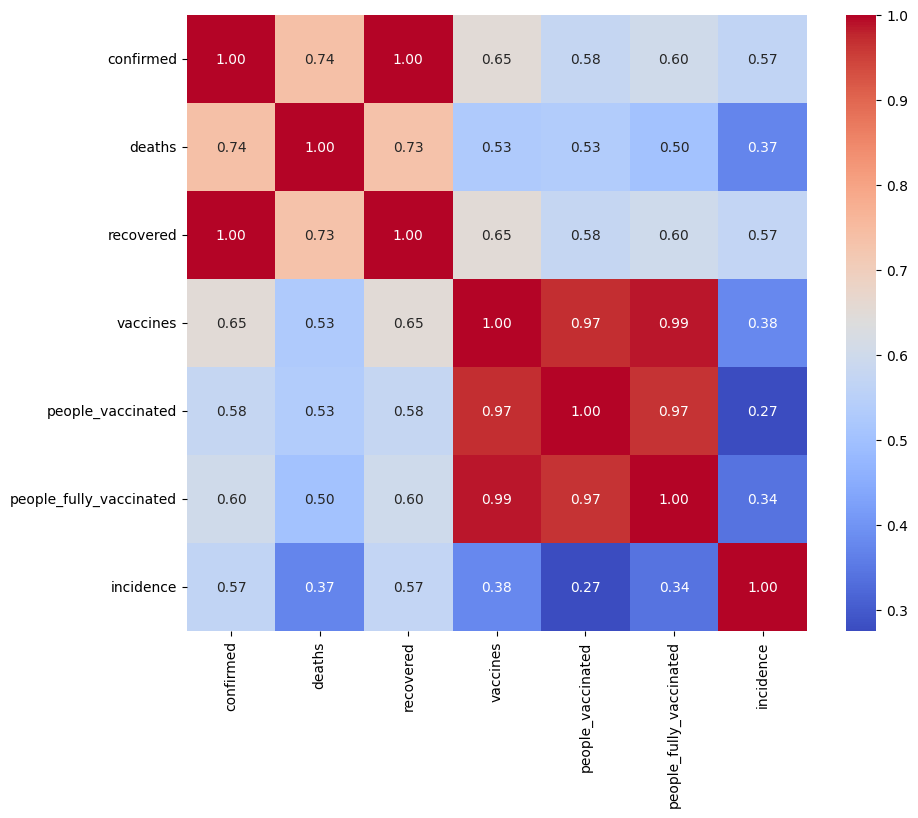

In [ ]:
epi_features = list(large_diff_inputs.columns[3:9])
epi_features.append(large_diff_inputs.columns[-2])
# Compute correlation matrix
corr_matrix = large_diff_inputs[epi_features].corr()

# Create a new figure with size 10x8 inches
fig = plt.figure(figsize=(10, 8))

# Plot correlation matrix using Seaborn's heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Show plot
plt.show()

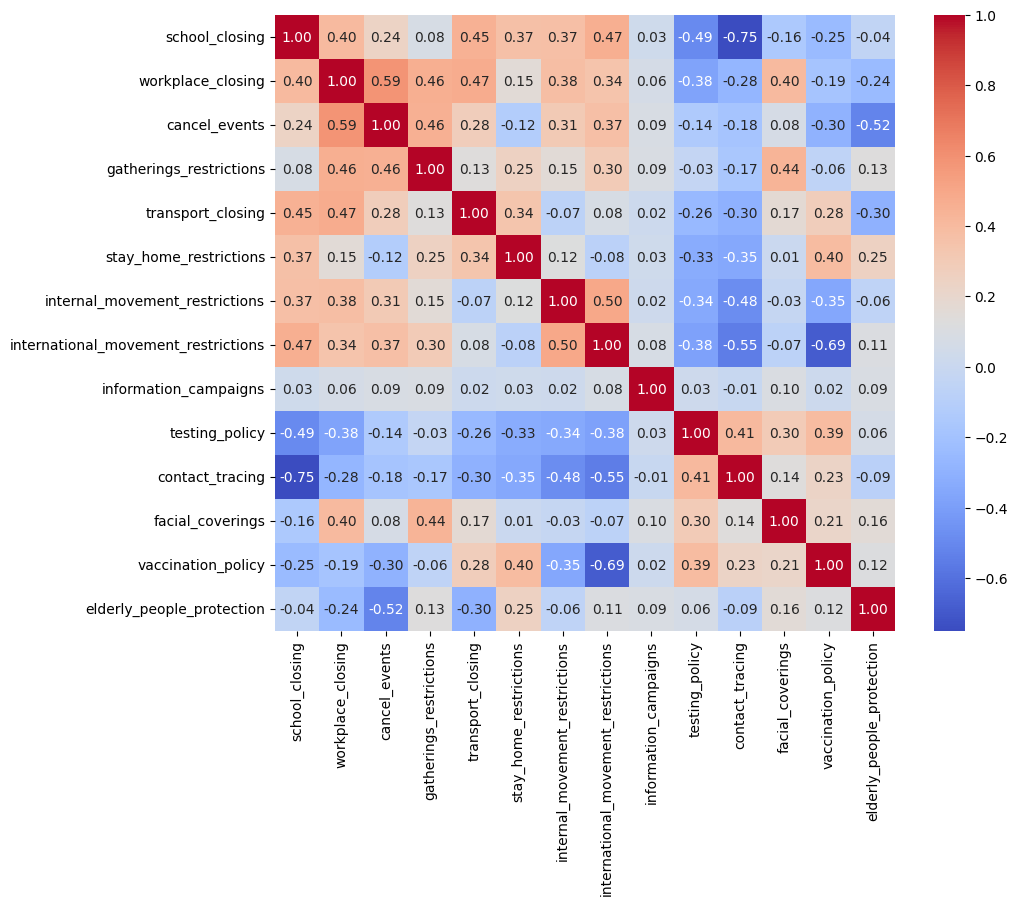

In [ ]:
policy_features = list(large_diff_inputs.columns[9:23])

# Compute correlation matrix
corr_matrix = large_diff_inputs[policy_features].corr()

# Create a new figure with size 10x8 inches
fig = plt.figure(figsize=(10, 8))

# Plot correlation matrix using Seaborn's heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Show plot
plt.show()

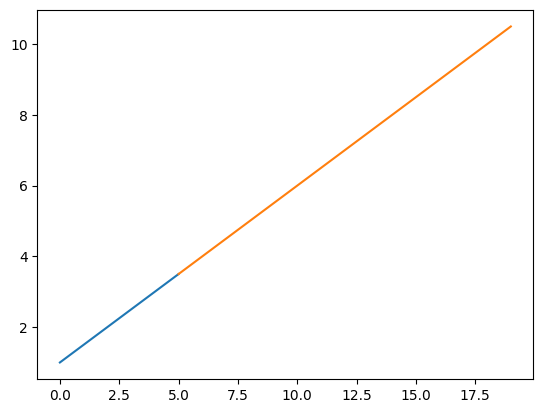

In [ ]:
x = np.arange(0,20)
y = np.arange(1,11,0.5)
z = np.copy(y)

y[6:] = np.nan
z[:5] = np.nan


plt.plot(x,y)
plt.plot(x,z)

In [ ]:
A = [1,2,3]

np.empty(len(A))

array([0.45610992, 0.00120404, 0.01966013])

In [ ]:



# def coloring(string,color="normal",style="normal"):
#     col = "0"
#     sty = "2"
#     if color == "blink":
#         col = "5"
#     elif   color == "red":
#         col = "31"
#     elif color == "green":
#         col = "32"
#     elif color == "yellow":
#         col = "33"
#     elif color == "blue":
#         col = "34"
#     elif color == "purple":
#         col = "35"

#     if style == "bold":
#         sty = "1"
#     elif style == "italic":
#         sty = "3"
#     elif style == "curl":
#         sty = "4"
#     elif style == "blink1":
#         sty = "5"
#     elif style == "blink2":
#         sty = "6"
#     elif style == "selected":
#         sty = "7"

#     return "\x1b[{}m\x1b[{}m{}\x1b[0m".format(col,sty,string)




# print("Prediction for: {}".format(coloring(TARGET_COLUMN,"yellow")))

# column_string = "    {}    | {}  | {} |  {}".format(coloring("Row","blue","bold"),coloring("Expected","green","bold"),coloring("Predicted","purple","bold"),coloring("abs(Diff)","red","bold"))
# print("{:#<50s}\n{}\n{:-<50s}".format("",column_string,""))
# for i, row in enumerate(except_taget_rows.index.values):
#     values_predict = de_scaled_prediction[i]
#     values_is = except_taget_rows.loc[row][TARGET_COLUMN]
#     # print("Zeile {} | {} (Predicted): {:.1f} , {} (Is): {:.1f}, |Diff|: {:.2f} ".format(row,TARGET_COLUMN,values_predict, TARGET_COLUMN ,values_is, abs(values_predict-values_is))) 
#     diff = abs(values_predict-values_is)
#     print(" {: ^22} | {: ^22} | {: ^22} | {: ^22}".format(coloring(row,"blue"),coloring(f"{values_predict:.1f}","green"),coloring(f"{values_is:.1f}","purple"),coloring(f"{diff:.1f}","red"))) 


